# Endless Runner Q-table training

Heavily inspired on the Q-table Colab notebook from Huggingface's DeepRL course: https://huggingface.co/learn/deep-rl-course/unit2/hands-on

(Aquí dejo esto para que no se me olvide. Para correr el ambiente, primero se debe instalar el paquete de GameEnvs, para hacer esto lo que hago es irme a /GameEnvs y corro pip install -e .)

## Import the packages

In [15]:
pip install -e GameEnvs

Obtaining file:///D:/Repository/GameDevsCSF/RL-environments/GameEnvsNote: you may need to restart the kernel to use updated packages.

  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Attempting uninstall: GameEnvs
    Found existing installation: GameEnvs 0.0.1
    Uninstalling GameEnvs-0.0.1:
      Successfully uninstalled GameEnvs-0.0.1
  Running setup.py develop for GameEnvs


By running the next cell, we'll kill the kernel to make sure the installed package is imported correctly.

In [16]:
# Restart the kernel after running this cell to make sure that the package is imported correctly.
import os
os._exit(00)

: 

Now we can run the next cell by stopping it and restarting the kernel.

In [1]:
import gymnasium as gym
import GameEnvs
import numpy as np
import random
from tqdm import tqdm
import matplotlib.pyplot as plt
import pandas as pd

## Create the environment

The range of distances in this particular environment goes from 50 (player_x - obstacle_width) to 800 (the set screen width)

Binning with 76 leads to an array like this: 
```
[ 50.  60.  70.  80.  90. 100. 110. 120. 130. 140. 150. 160. 170. 180.
 190. 200. 210. 220. 230. 240. 250. 260. 270. 280. 290. 300. 310. 320.
 330. 340. 350. 360. 370. 380. 390. 400. 410. 420. 430. 440. 450. 460.
 470. 480. 490. 500. 510. 520. 530. 540. 550. 560. 570. 580. 590. 600.
 610. 620. 630. 640. 650. 660. 670. 680. 690. 700. 710. 720. 730. 740.
 750. 760. 770. 780. 790. 800.]
```

In [2]:
bins = 76
env = gym.make("EndlessRunner-v0", obstacle_x_bins=bins, render_mode="none")

<frozen importlib._bootstrap>:488: RuntimeWarning: Your system is avx2 capable but pygame was not built with support for it. The performance of some of your blits could be adversely affected. Consider enabling compile time detection with environment variables like PYGAME_DETECT_AVX2=1 if you are compiling without cross compilation.


## Understanding our environment

In [3]:
print("Action space:", env.action_space)
print("Sample action:", env.action_space.sample())

Action space: Discrete(3)
Sample action: 1


The actions are: do nothing (0), jump (1) or duck (2)

## Initialize the Q-table
Need to discretize the observations to make the Q-table. The solution seems to be to bin the observations, the question is how.

We have the obstacle's x position, the obstacles y positon and the player's y positon.

- Obstacle x: Goes from being at x = 800 to x = 50 (behind the player). The bin size could translate into "how fast" the agent reacts to having an obstacle in front of it.
- Obstacle y: is either on the floor (0) or above the floor (1).

In [4]:
print("Observation space:", env.observation_space)
print("Sample observation:", env.observation_space.sample())

Observation space: Discrete(609)
Sample observation: 541


In [5]:
action_space = env.action_space.n
print("There are ", action_space, " actions in the action space.")

#observation_space = env.observation_space.spaces[0].n * env.observation_space.spaces[1].n 
observation_space = env.observation_space.n
print("There are ", observation_space, " observations in the observation space.")   

There are  3  actions in the action space.
There are  609  observations in the observation space.


In [6]:
def initialize_q_table(state_space, action_space):
    q_table = np.zeros([state_space, action_space])
    return q_table

Here, there's a column for each action and a row for each possible state. The way we'll index the rows is the following: as there's two observations we take from the environment, the obstacle's x position [0, ..., number_of_bins] and its height (0 for floor height and 1 for above floor height), we take the x position's bin index and we add it to the bin size multiplied times the obstacle height (obstacle_x_position_binned_index + number_of_bins * obstacle_height)

In [7]:
Qtable_runner = initialize_q_table(observation_space, action_space)
print("Qtable shape:", Qtable_runner.shape)
print("Qtable:", Qtable_runner)

Qtable shape: (609, 3)
Qtable: [[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 ...
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]


### Greedy policy
Now we'll define the policy that's going to be used to update our Q-table, which is called a Greedy Policy, this means that we'll always select the action that gives us the biggest reward.

In [8]:
def greedy_policy(Qtable, state):
  # Exploitation: take the action with the highest state, action value
  action = np.argmax(Qtable[state][:])

  return action

### Epsilon Greedy Policy
Next is the Epsilon Greedy Policy, that handles the exploration vs exploitation tradeoff during the acting phase of the training.

The ɛ is used to determine the probability of selecting a greedy action, the action that we know gives the current highest reward, also known as exploitation or trying a random action, also know as exploration.

- With probability 1 - ɛ, we do exploitation.
- With probability ɛ, we do exploration.

The idea here is that we start reducing the value of epsilon with a given frequency in order to exploit our aquired knowledge as time passes.

In [9]:
def epsilon_greedy_policy(Qtable, state, epsilon):
  # Randomly generate a number between 0 and 1
  random_num = random.uniform(0,1)
  # if random_num > greater than epsilon --> exploitation
  if random_num > epsilon:
    # Take the action with the highest value given a state
    # np.argmax can be useful here
    action = greedy_policy(Qtable, state)
  # else --> exploration
  else:
    action = env.action_space.sample()

  return action

### Defining hyperparameters
Here, we'll define the hyperparameters, which are values that related to the training itself, so things like the number of episodes, learning rate, discount rate, decay rate, etc.

In [10]:
# Training parameters
n_training_episodes = 200000  # Total training episodes
learning_rate = 0.4          # Learning rate

# Evaluation parameters
n_eval_episodes = 100        # Total number of test episodes

# Environment parameters
env_id = "EndlessRunner-v0"     # Name of the environment
max_steps = 20000               # Max steps per episode
gamma = 0.95                 # Discounting rate
eval_seed = []               # The evaluation seed of the environment

# Exploration parameters
max_epsilon = 1.0             # Exploration probability at start
min_epsilon = 0.05            # Minimum exploration probability
decay_rate = 0.0005            # Exponential decay rate for exploration prob

In [11]:
# Plotting variables
rewards_vs_time = pd.DataFrame(columns=['Reward', 'Time', 'Epsilon'])

### Training :O
Training loop (explanation from HF's course)

The training loop goes like this:

```
For episode in the total of training episodes:

Reduce epsilon (since we need less and less exploration)
Reset the environment

  For step in max timesteps:    
    Choose the action At using epsilon greedy policy
    Take the action (a) and observe the outcome state(s') and reward (r)
    Update the Q-value Q(s,a) using Bellman equation Q(s,a) + lr [R(s,a) + gamma * max Q(s',a') - Q(s,a)]
    If done, finish the episode
    Our next state is the new state
```

In [12]:
def train(n_training_episodes, min_epsilon, max_epsilon, decay_rate, env, max_steps, Qtable, rewards_vs_time):
  for episode in tqdm(range(n_training_episodes)):
    # Reduce epsilon (because we need less and less exploration)
    epsilon = min_epsilon + (max_epsilon - min_epsilon)*np.exp(-decay_rate*episode)
    # Reset the environment
    state, info = env.reset()
    step = 0
    terminated = False
    truncated = False

    # repeat
    for step in range(max_steps):
      # Choose the action At using epsilon greedy policy
      action = epsilon_greedy_policy(Qtable, state, epsilon)

      # Take action At and observe Rt+1 and St+1
      # Take the action (a) and observe the outcome state(s') and reward (r)
      new_state, reward, terminated, truncated, info = env.step(action)

      # Update Q(s,a):= Q(s,a) + lr [R(s,a) + gamma * max Q(s',a') - Q(s,a)]
      Qtable[state][action] = Qtable[state][action] + learning_rate * (reward + gamma * np.max(Qtable[new_state]) - Qtable[state][action])
      
      # At the end of each episode, append the reward and time to the DataFrame
      
      # If terminated or truncated finish the episode
      if terminated or truncated:
        break

      # Our next state is the new state
      state = new_state
    
    rewards_vs_time.loc[len(rewards_vs_time)] = {'Reward': info["dodges"], 'Time': episode, 'Epsilon': epsilon}
  return Qtable, rewards_vs_time

## Train the Q-learning agent

In [13]:
Qtable_runner, rewards_vs_time = train(n_training_episodes, min_epsilon, max_epsilon, decay_rate, env, max_steps, Qtable_runner, rewards_vs_time)

  0%|          | 0/200000 [00:00<?, ?it/s]c:\Users\Prod\miniconda3\envs\rl-lab-dev\Lib\site-packages\gymnasium\utils\passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):
100%|██████████| 200000/200000 [48:13<00:00, 69.13it/s]  


Let's see our new Q-table

In [14]:
Qtable_runner

array([[ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       ...,
       [-0.00734441, -0.00738467, -0.00703861],
       [-0.00669314, -0.00671588, -0.00671997],
       [-0.00637277, -0.00635083, -0.00638503]])

### Plotting

Now we'll plot important information about the training in order to get important insights about its performance

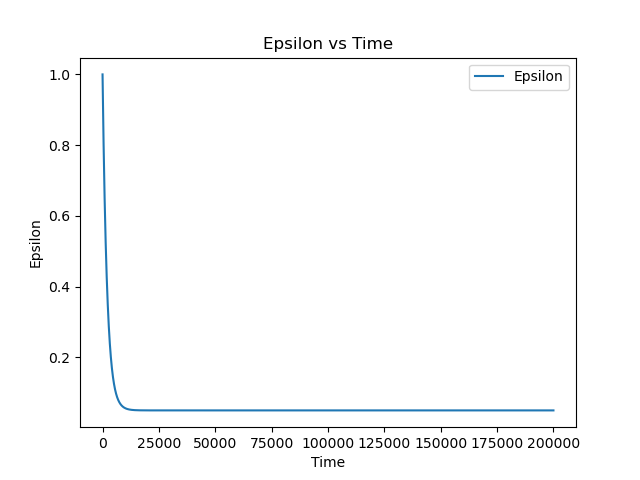

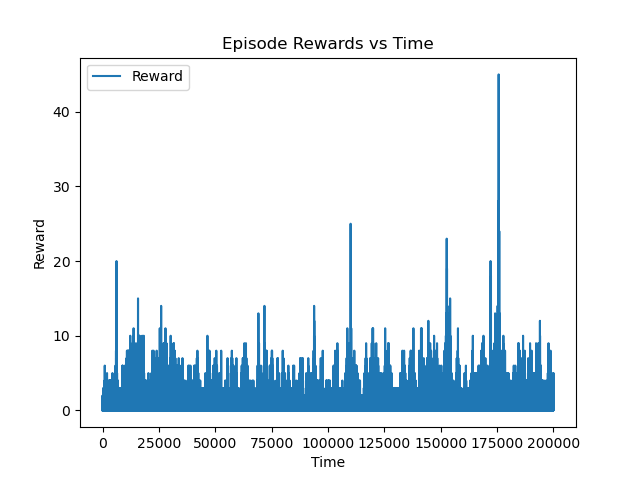

In [15]:
# Plot the rewards vs time

# Create the plot
%matplotlib widget
plt.ion()

# Plot the rewards vs time
rewards_vs_time.plot(x='Time', y='Reward', kind='line')
# Set the title and labels
plt.title('Episode Rewards vs Time')
plt.xlabel('Time')
plt.ylabel('Reward')

# Plot the epsilon vs time
rewards_vs_time.plot(x='Time', y='Epsilon', kind='line')
# Set the title and labels
plt.title('Epsilon vs Time')
plt.xlabel('Time')
plt.ylabel('Epsilon')

# Show the plot
plt.show()

In [16]:
#np.save("Qtable_runner.npy", Qtable_runner)

In [17]:
# Visualize the agent
env = gym.make("EndlessRunner-v0", obstacle_x_bins=bins, render_mode="human")
env.reset()
state, info = env.reset()
step = 0
terminated = False
truncated = False
while not terminated and not truncated:
    action = greedy_policy(Qtable_runner, state)
    state, reward, terminated, truncated, info = env.step(action)
    step += 1
    # print("Step: ", step)
    # print("Action: ", action)
    # print("State: ", state)
    # print("Reward: ", reward)
    # print("Info: ", info)
    env.render()
#env.close()

c:\Users\Prod\miniconda3\envs\rl-lab-dev\Lib\site-packages\gymnasium\utils\passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


In [18]:
#env.close()